In [1]:
import sys
import time
import numpy as np
import pylab as pl
import tables as pytb
import os

sys.path.append('../') # get out of the sandbox

from vent.controller.control_module import get_control_module, Balloon_Simulator
from vent.common.message import SensorValues, ControlSetting
from vent.common.values import ValueName, CONTROL

In [2]:
os.chdir('../');
Controller = get_control_module(sim_mode=True)

In [3]:
Controller.start()

ls = []
tt = []
t0 = time.time()
for t in np.arange(0, 10,0.05):
    
    if t%5==0:  # ask for a heartbeat from thread every 5 seconds
        print(t)
    
    
    ## Do things
    command = ControlSetting(name=ValueName.PEEP, value=3, min_value=1, max_value=4, timestamp=time.time())
    Controller.set_control(command)

    command = ControlSetting(name=ValueName.PIP, value=40, min_value=38, max_value=42, timestamp=time.time())
    Controller.set_control(command)

    command = ControlSetting(name=ValueName.BREATHS_PER_MINUTE, value=20, min_value=19, max_value=21, timestamp=time.time()) 

    Controller.set_control(command)

    v_iphase = 0.4 * 60/20  #0.3 and 0.8
    command = ControlSetting(name=ValueName.INSPIRATION_TIME_SEC, value=v_iphase, min_value=v_iphase - 1, max_value=v_iphase + 1, timestamp=time.time())
    Controller.set_control(command)
    
    ##
    
    
    vals = Controller.get_sensors()
    ls.append(vals)
    tt.append(time.time()  - t0)
    
    time.sleep(0.05)
    
Controller.stop()

0.0
5.0


In [4]:
# Get the target waveform, and plot together with the last measured waveform

In [4]:
pas_wv = Controller.get_past_waveforms()
wv = Controller.get_target_waveform()

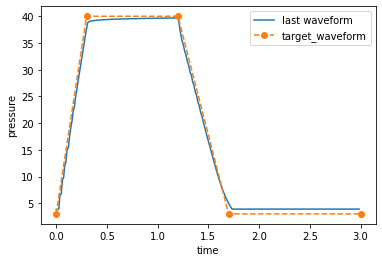

In [5]:
lastwv = pas_wv[-1]
pl.plot(lastwv[:,0], lastwv[:,1], label='last waveform')
pl.plot([pt[0] for pt in wv], [pt[1] for pt in wv], '--o', label = 'target_waveform')
pl.legend()
pl.xlabel('time')
pl.ylabel("pressure");

In [7]:
# Subsampled data

Text(0.5, 0, 'time [s]')

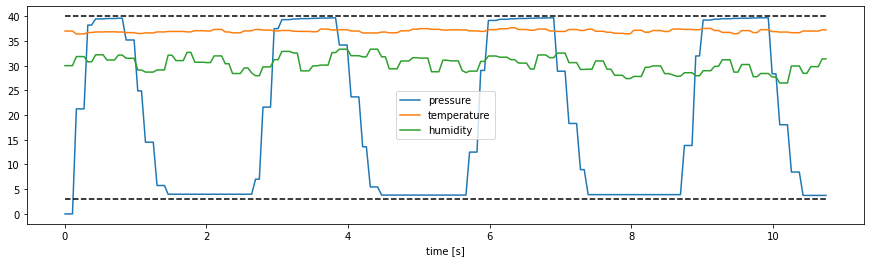

In [6]:
pl.rcParams['figure.figsize'] = [15, 4]

cc = Controller.get_control(control_setting_name = ValueName.PEEP)
peep = cc.value

cc = Controller.get_control(control_setting_name = ValueName.PIP)
pip = cc.value

pl.plot(tt, [s.PRESSURE for s in ls], label = 'pressure')
pl.plot(tt, [s.TEMP for s in ls], label = "temperature")
pl.plot(tt, [s.HUMIDITY/3 for s in ls], label = "humidity")
pl.plot([np.min(tt), np.max(tt)], [pip, pip], 'k--')
pl.plot([np.min(tt), np.max(tt)], [peep, peep], 'k--')
    
pl.legend()
pl.xlabel("time [s]")

In [7]:
dff = Controller.dl.load_file()

Reading... vent/logfiles/2020-05-21-17-28_controller_log.h5


In [10]:
ls_wv = dff['waveform_data']
ls_ct = dff['control_data']

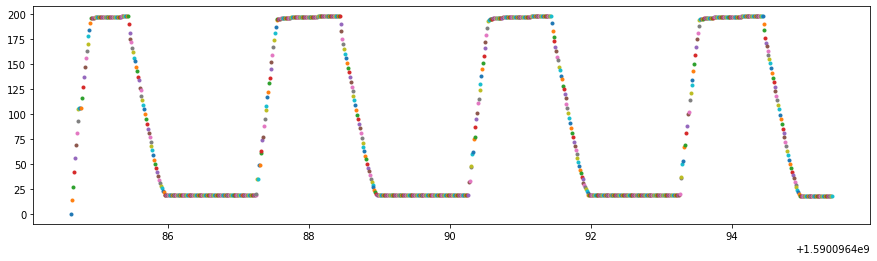

In [11]:
for p in ls_wv:
    pl.plot(p[4], p[3],'.') #pressure

# Plotting

In [1]:
from vent.controller.control_module import get_control_module
from vent.common.logging import DataLogger
import numpy as np
import pylab as pl

2020-06-04 11:44:11,027 - vent.common.prefs - INFO - Loaded prefs from /Users/ms81/vent/prefs.json
2020-06-04 11:44:11,032 - vent.common.prefs - INFO - Saved prefs to /Users/ms81/vent/prefs.json


In [2]:
dl = DataLogger()

In [44]:
# dff = dl.load_file("../../2020-06-03-15-44_controller_log.0.h5") #only state control
# dff = dl.load_file("../../2020-06-03-15-51_controller_log.0.h5") #only PID
# dff = dl.load_file("../../2020-06-03-16-01_controller_log.0.h5") #only PID gain 20
# dff = dl.load_file("../../2020-06-03-16-19_controller_log.0.h5") #pid gain 10
# dff = dl.load_file("../../2020-06-03-16-23_controller_log.0.h5") #23 pid gain 1
dff = dl.load_file("../../2020-06-03-16-25_controller_log.0.h5")#25 10-20 as limits, pid gain 2
dff = dl.load_file("../../2020-06-03-16-28_controller_log.0.h5")#28 10-20 as limits, pid gain 3

dff = dl.load_file("../../2020-06-04-12-09_controller_log.0.h5") #5 - 35 HAPA alert
dff = dl.load_file("../../2020-06-04-12-24_controller_log.0.h5") #5 - 35 HAPA alert

Reading... ../../2020-06-03-16-25_controller_log.0.h5
Reading... ../../2020-06-03-16-28_controller_log.0.h5
Reading... ../../2020-06-04-12-09_controller_log.0.h5
Reading... ../../2020-06-04-12-24_controller_log.0.h5


In [45]:
ls_wv = dff['waveform_data']
ls_ct = dff['control_data']

In [46]:
data = np.zeros((len(ls_wv),2))
for idx in range(len(ls_wv)):
    data[idx,0] = ls_wv[idx][4]
    data[idx,1] = ls_wv[idx][3]

Text(0, 0.5, 'pressure [cmH2O]')

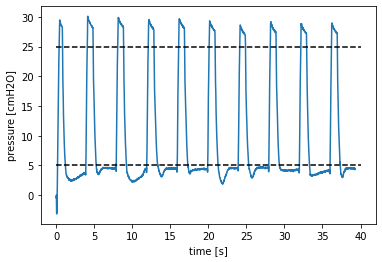

In [48]:
pl.plot(data[:,0] - np.min(data[:,0]), data[:,1])
pl.plot([0,40],[5,5],'k--')
pl.plot([0,40],[25,25],'k--')

# pl.xlim([7,10])
# pl.ylim([8,22])
pl.xlabel("time [s]")
pl.ylabel("pressure [cmH2O]")